<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_05_CNN_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks Architectures
In this tutorial, we will learn about well-known CNN architectures in the field of computer vision and how to implement them in Keras. 






# CNNs in Image Classification
We will start this tutorial by presenting the networks that have been widely used for image classification.  (One of the most famous problems among the computer vision community is the annual software contest run by the ImageNet project, **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)**. This task evaluates how well an algorithm does in the tasks of object category classification and detection on hundreds of object categories and millions of images. 

As ImageNet is a massive dataset, we will use instead CIFAR100 dataset, which is directly available on Keras. 

CIFAR10 dataset contains 10 different classes and 32x32 images, instead of 224x224 as in ImageNet. We will show how to resize the data to be able to use some of the following architectures, as not all of the CNN accepts arbitrary input sizes. The ones that do, will use the original CIFAR10 input size. 

In [1]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 3s 0us/step


To resize the dataset, and as a CIFAR100 224x224 version would not fit in our RAM, we need to create a preprocessing step before the first layer. This step will resize the input batch to the required size. To do so, we use the `Lambda` layer in Keras, which wraps any expression (in this case `resize_images`) in a layer. We can see how this function looks like for a single batch of 32 images.

(32, 224, 224, 3)


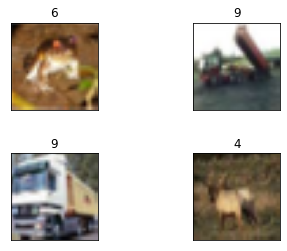

In [2]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as ktf
ktf.logging.set_verbosity(ktf.logging.ERROR)


inp = Input(shape=(32, 32, 3))
out = Lambda(lambda image: ktf.image.resize_images(image, (224, 224)))(inp)

model = Model(inputs=inp, outputs=out)

x_train_resized = model.predict(x_train[:32, ...])
print(x_train_resized.shape)

# Visualization purposes
x_train_resized = np.asarray(x_train_resized, dtype = np.int)
    
# Let's visualize some examples
N=2
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = list(range(0, 100))
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(x_train_resized[idx], cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    y_target = int(y_train[idx])
    target = str(items[y_target])
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Let's get ready the dataset:

In [3]:
num_classes = 10
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

print('Original training data shape: {}'.format(x_train.shape))
print('Training label shape: {}'.format(y_train.shape))

Original training data shape: (50000, 32, 32, 3)
Training label shape: (50000, 10)


## AlexNet

AlexNet made a huge impact in 2012 when it reduced the top-5 error (i.e. the correct class is not among the top-5 predictions) from 26% to 15.3% in the ImageNet challenge. The second place was close to 26.2%, and it was not a CNN based system. AlexNet shares a lot with its predecessor architecture, [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) by Yann LeCun et al. However, in this case, the computational complexity was more plausible to deal with that it was years before, therefore, authors decided to make the architecture bigger: more convolutional layers and more filters. 

The architecture designed in their paper:

![texto alternativo](https://i.ibb.co/QFG561f/0-x-POQ3bt-Z9r-QO23-LK.png)

The network consisted of convolutional layers with kernels of 11x11, 5x5 and 3x3. The architecture uses layers with strides, max poolings, dropouts, ReLU activation functions, and three dense layers at the end. The original network was split in two, as seen in the figure above, however, due to GPU constraints authors needed to train it on two separate GPUs. We found a great implementation in [Rizwan's blog](https://engmrk.com/alexnet-implementation-using-keras/), where it presented an AlexNet model without the split concept.

In [0]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

model = Sequential()

# Resize input image
model.add(Lambda(lambda x: ktf.image.resize_images(x, (224, 224)), input_shape=(32,32,3)))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(10))
model.add(Activation('softmax'))

Now, we are ready to train this AlexNet model on CIFAR100. 

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=3)


Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 63s 2ms/step - loss: 2.3048 - acc: 0.0997 - val_loss: 2.3030 - val_acc: 0.0952
Epoch 2/3
40000/40000 [==============================] - 54s 1ms/step - loss: 2.3029 - acc: 0.0990 - val_loss: 2.3029 - val_acc: 0.0977
Epoch 3/3
40000/40000 [==============================] - 55s 1ms/step - loss: 2.3028 - acc: 0.0978 - val_loss: 2.3027 - val_acc: 0.0952


Let's test it:

In [6]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 277us/step
Test loss: 2.302612992477417
Test accuracy: 0.1


Training this kind of architectures in big datasets is time-consuming. We might need to train for several hours to start getting good results. That is why Keras offers several pre-trained models on the ImageNet dataset. Those models can be used directly for image prediction, image classification, feature extraction, or fine-tuning, among others, without the need of spending long hours of training. Even if the task or the dataset is different, using the pre-trained weights as initialization for the training process provides usually quite better results (as well as less time needed for training and better accuracy) than using a random initialization.

# Loading Pre-trained Models in Keras

As mentioned, Keras contains many models that have been pre-trained in the ImageNet dataset to solve the ILSVRC competition. Those deep learning models are made available alongside their pre-trained weights, which has become a common practice to initialize networks. You can learn more about it [here](https://keras.io/applications/). 

We will show how to instantiate the models and load their weights. Afterward, we will modify the last layer to classify only the 10 classes belonging to CIFAR10.

## VGGNet

VGGNet is an architecture presented by Simonyan and Zisserman in 2014. VGGNet is similar to previous AlexNet, however, it only contains 3x3 convolutional kernels and many more filters. It is widely used for extracting features, not only for image classification but for many other computer vision domains, such as feature representation, style transfer or the image description. You can check the [paper](https://arxiv.org/pdf/1409.1556.pdf) for further details. Next image shows VGG16 architecture ([source](https://www.cs.toronto.edu/~frossard/post/vgg16/)):

![](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

The training time of the architecture is massive since it has more than 130 million parameters. Thankfully, we can find it already pre-trained in Keras. Keras has the two proposed versions, VGG16 and VGG19, where the difference lies in the number of weight layers within the network.


In [7]:
from keras.applications.vgg16 import VGG16

model = VGG16(input_shape=(224, 224, 3))

# Optionally, uncomment the following line to display the full model
# model.summary()

553467904/553467096 [==============================] - 6s 0us/step


If we want to load weights from ImageNet we only need to initialize the model as follows:

In [0]:
model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

Now, we want to change the last layer for one dense layer with 10 activation neurons. This new layer will allow us to perform classification on CIFAR10. Besides, we will freeze all pre-trained layers and only allow the new dense layer to be trained. 

In [0]:
from keras.models import Model
from keras.layers import Dense

#Load the VGG
model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False
    
output = model.get_layer('fc2').output
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

Let's see the model now, and confirm that the last layer is not there anymore, and instead, we have a new dense layer with only 10 activations. Also, as we have frozen the weights of the model, we should see only the trainable parameters belonging to the new dense layer.

In [10]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

 As we have done before, we can add the lambda function to resize the images within our Keras model:

In [0]:
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: ktf.image.resize_images(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

If we want to use images of 32x32 we need to set the argument `include_top` to `False`, which will remove all dense layers at the end of the architecture. The dense layers in VGG are the ones that limit the input size to be 224x224 as they need a fixed dimension as input. Also, note that due to the MaxPooling operations, we need inputs of at least 32x32. If we remove the dense layers, we need to include new ones before starting the training process.



In [12]:
from keras.layers import Dense, Flatten

model = VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer as in VGG16
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

58892288/58889256 [==============================] - 1s 0us/step


Now we have trainable parameters belonging to the last layers, so we are ready to fine-tune the VGG architecture.

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 34s 854us/step - loss: 1.3732 - categorical_accuracy: 0.5148 - val_loss: 1.2615 - val_categorical_accuracy: 0.5589
Epoch 2/3
40000/40000 [==============================] - 33s 820us/step - loss: 1.1720 - categorical_accuracy: 0.5875 - val_loss: 1.1795 - val_categorical_accuracy: 0.5903
Epoch 3/3
40000/40000 [==============================] - 33s 823us/step - loss: 1.0835 - categorical_accuracy: 0.6168 - val_loss: 1.1890 - val_categorical_accuracy: 0.5849


Let's evaluate it:

In [14]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 283us/step
Test loss: 1.1923199825286865
Test accuracy: 0.5851


## GoogLeNet / Inception v1

Google presented [GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) in 2014, the same year that VGGNet was introduced.  GoogLeNet won the ImageNet competition achieving a top-5 error rate of 6.67%, almost betting the human error rate (5%). 

GoogLeNet introduced many ideas that helped the development of current state-of-the-art architectures. Instead of stacking more and more CNN layers, GoogLeNet introduced what the called inception modules:
 
![](https://i.ibb.co/JKqptrj/Googlenet-inception.png)

Those modules apply convolutions with 3 different sizes of kernels (1x1, 3x3 and 5x5) at the same level. The idea behind those modules is based on the premise that significant information can be presented in images at numerous different sizes. Therefore, by using a multi-scale approach, they are more likely to capture meaningful information. Moreover, they claimed that by designing a wider, instead of deeper, architecture helps the gradients to go through the entire network easily.

![](https://cdn-images-1.medium.com/max/1600/1*uW81y16b-ptBDV8SIT1beQ.png)

The architecture consisted of 9 inception modules stacked linearly, containing 22 deep CNN layers, however, the total number of parameters was reduced to 4 millions! Authors also included two auxiliary classifiers in the middle part of the architecture to avoid the vanishing gradient problem.

You can find a Keras implementation [here](https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14).

Original Inception v1 was a complex and heavily engineered architecture, and therefore many tricks were presented to push its performance, both in terms of speed and accuracy. The constant evolution of the architecture leads to the creation of several versions, a list and explanation of their differences can be found in [this blog](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).  

In Keras, the Inception v3 architecture is available, together with its pre-trained weights on ImageNet. It can be initialized as follows:

In [15]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=True, weights='imagenet', classes=1000)

96116736/96112376 [==============================] - 1s 0us/step


We can see its performance in CIFAR10. First of all, we will resize images to 75x75  which is the minimum size required by Inception v3 to work:

In [16]:
from keras.models import Model
from keras.layers import Lambda, Input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(include_top=False, input_shape=(75, 75, 3), weights='imagenet')

# Resize Input images to 75x75
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: ktf.image.resize_images(image, (75, 75)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer to classify on CIFAR100
output = model.output
output = GlobalAveragePooling2D()(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 75, 75, 3)         0         
_________________________________________________________________
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


We can train Inception v3:

In [17]:
print(x_train.shape)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2)

(50000, 32, 32, 3)
Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 34s 859us/step - loss: 1.8557 - categorical_accuracy: 0.3576 - val_loss: 2.2484 - val_categorical_accuracy: 0.3398
Epoch 2/3
40000/40000 [==============================] - 27s 668us/step - loss: 1.6878 - categorical_accuracy: 0.4235 - val_loss: 2.2527 - val_categorical_accuracy: 0.3607
Epoch 3/3
40000/40000 [==============================] - 26s 651us/step - loss: 1.6549 - categorical_accuracy: 0.4336 - val_loss: 2.3034 - val_categorical_accuracy: 0.3538


And check its accuracy:

In [18]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 536us/step
Test loss: 2.311893310546875
Test accuracy: 0.3535


## ResNet

In 2015 the winner of the ImageNet challenge was the Residual Neural Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf)) architecture. Similar to Inception, ResNet is built by micro-architectures modules, called residual blocks. Those blocks introduced skip connections, which allowed to train huge architectures (152 layers) while still having lower complexity than VGGNet. Those residual connections also allowed them to create deeper architectures since the gradient could backpropagate easier through the skip connections. Next image is from [Das' blog](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) and shows ResNet architecture with its skip connections:

![texto alternativo](https://cdn-images-1.medium.com/max/800/0*pkrso8DZa0m6IAcJ.png)

Keras offers the implementation of ResNet50 pre-trained on ImageNet. In addition to ResNet50, deeper versions of it, ResNet101 or ResNet152, are widely used nowadays. The main difference lies in the number of layers, e.g., ResNet50 is a 50 layer Residual Network.

In [19]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50

model = ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')

# Freeze all the layers
for layer in model.layers[:]:
    layer.trainable = False

# Add Dense layer to classify on CIFAR10
output = model.output
output = GlobalAveragePooling2D()(output)
output = Dense(units=10, activation='softmax')(output)
model = Model(model.input, output)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


Let's check the performance:

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2)

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 26s 649us/step - loss: 1.9397 - categorical_accuracy: 0.3973 - val_loss: 5.5953 - val_categorical_accuracy: 0.1062
Epoch 2/3
40000/40000 [==============================] - 19s 485us/step - loss: 1.7006 - categorical_accuracy: 0.4552 - val_loss: 6.1810 - val_categorical_accuracy: 0.1014
Epoch 3/3
10000/10000 [==============================] - 4s 379us/step
Test loss: 5.459840525054932
Test accuracy: 0.1008


## Xception, DenseNet, InceptionResNet ...

Keras offers many more network implementations trained on ImageNet. You can check the [documentation](https://keras.io/applications/) to see all of them. Besides, the documentation reports their accuracies, number of parameters and depth of each architecture. 

# CNN on Others Domains

Besides the success of CNNs in classification problems, CNNs have been used in many other domains, such as object detection, facial recognition, image segmentation, image captioning, image generation, among others. We present now two state-of-the-art architectures.


## Denoising with UNet

[UNet](https://arxiv.org/pdf/1505.04597.pdf) was presented in 2015 for biomedical image segmentation, but since then, it has been employed in many different tasks such as as semantic segmentation, generative models, denoising... The idea is similar to an encoder-decoder layout. The first part of the network encodes the image and reduces it to a map of smaller size, forcing it to capture the important information. Then, the next part is in charge of decoding the image from that vector.

UNet presents also skip connections between the encoder and the decoder to allow easier flow of information.


Now let's define the UNet architecture.


In [0]:
from keras.layers import Input, UpSampling2D, concatenate 
from keras.models import Model

inputs = Input((32,32,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
drop5 = Dropout(0.5)(conv5)

## Now the decoder starts

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

model = Model(inputs = inputs, outputs = conv10)

We have CIFAR10 images loaded from previous experiments. We are going to add some Gaussian noise (you can play with the scale of the noise) and then train the UNet to remove the noise from the images. To do so, we train with the noisy image as input and the clean image as the target. We use the Mean Absolute Error as the loss function to optimize the architecture.

In [22]:
import numpy as np

x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(x_train_noise, x_train, batch_size=32, epochs=3, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 76s 2ms/step - loss: 0.0875 - mean_absolute_error: 0.0875 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 2/3
40000/40000 [==============================] - 67s 2ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 3/3
40000/40000 [==============================] - 68s 2ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325


In [0]:
pred = model.predict(x_test_noise)

We now visualize the noisy image next to the output of the UNet. The output images are a little bit blurred, but the noise has been reduced.

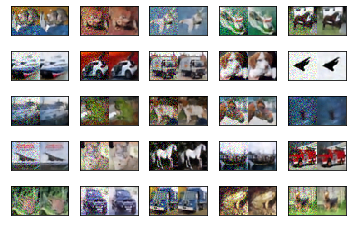

In [24]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_test_noise[idx], 0, 1), np.clip(pred[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])


## Object Detection with RetinaNet

We now will show an object detection example. Object detection differs from image classification in that in an image classification setting we give a label to the whole image, whereas in an object detection setting we give a label and bounding box per each of the classes that are present. 

Top detector models include Faster R-CNN, YOLO (yes, it is called YOLO, standing for You Only Look Once; this is the unusual [resume](https://pjreddie.com/static/Redmon%20Resume.pdf) of the YOLO developer) or SSD (Single Shot Detector). Another example of a detector is RetinaNet, which we use to give an example of object detection using the implementation taken from [this repository](https://github.com/fizyr/keras-retinanet). We adapt the example from [this notebook](https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb) in the given repository.

In [25]:
!git clone https://github.com/fizyr/keras-retinanet
%cd ./keras-retinanet
!python setup.py build_ext --inplace
%cd /content/
!pip install keras-resnet
%cd /content/keras-retinanet
!wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# We import a bunch of modules
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# load retinanet model
model_path = './resnet50_coco_best_v2.1.0.h5'
model = models.load_model(model_path, backbone_name='resnet50')
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

%cd /content/

def detection_url(url):
  %cd /content/keras-retinanet
  import requests
  from io import BytesIO
  response = requests.get(url)
  # load image
  image = read_image_bgr(BytesIO(response.content))

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < 0.5:
          break
      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()
  %cd /content/

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 5452 (delta 5), reused 1 (delta 0), pack-reused 5436
Receiving objects: 100% (5452/5452), 13.33 MiB | 30.19 MiB/s, done.
Resolving deltas: 100% (3643/3643), done.
/content/keras-retinanet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Now, we can use any *URL* pointing to an image (some *URLs* may fail) as input, and we will get an output with the detections out of the 80 classes in Microsoft COCO. If you want to check the classes available, you can print the variable labels_to_names.

As an example, we of course input an image full of cats. The labels are a bit blurry, but you can see all of the cats have the correct bounding box around them. However, one of the cats (third bottom row, blue box) was classified as a bear.

/content/keras-retinanet
processing time:  5.314215421676636


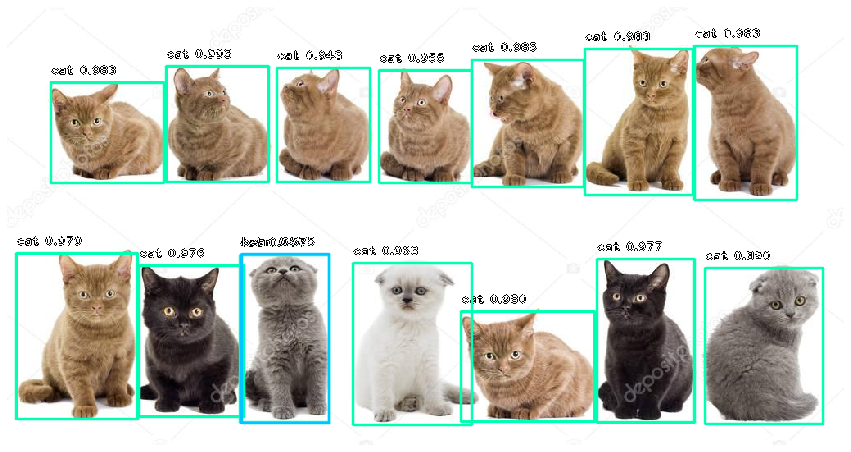

/content


In [26]:
url = 'https://st3.depositphotos.com/1032808/12984/i/950/depositphotos_129842732-stock-photo-group-of-various-breeds-cats.jpg'
detection_url(url)

# **Coursework**

### Task 1: VGG on Tiny-ImageNet

Explore the VGG Keras's model on 64x64 Tiny-ImageNet. Tiny-ImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones.

In this exercise you are asked to train several VGG models and report the result after 20 epochs of training. Run the following script to get the data.




Using TensorFlow backend.


Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 34.74 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
starting loading data
finished loading data, in 17.0954372882843 seconds


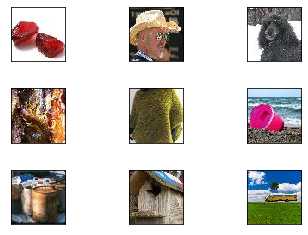

In [1]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU 
from keras import layers
from keras import models
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
        
    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        
        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()
        
        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        
        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)
  
def shuffle_data(train_data, train_labels, val_data, val_labels):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)
    
    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col    
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)


**Report**:
*   Compare results when training from scratch or loading pre-trained weights from ImageNet. Report also results when loading ImageNet weights, freezing all but the last dense layers, and retraining the model.
*   Compare results for the input image of size 64x64 and 224x224.
*   Report best results of VGG-16 and VGG-19 in terms of accuracy and inference time.

In [0]:
# model = . . .

model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(train_data, train_labels, epochs=20, batch_size=256, validation_data=(val_data, val_labels))

score = model.evaluate(test_data, test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



---



---


### Task 2: Building ResNet 101 and 152

As mentioned above, Keras offers the implementation of ResNet50 pre-trained on ImageNet. However, deeper versions of it, ResNet101 or ResNet152, are widely used nowadays and are not in Keras package. Here we are going to code them and test their performances.

![texto alternativo](https://cdn-images-1.medium.com/max/800/0*pkrso8DZa0m6IAcJ.png)

From the figure, we could extract each of the 50, 101 and 152 layer ResNet architecture designs. In the top-right legend of the above figure, three vectors are indicating the number of times that one block is repeated for each ResNet version. For instance, for ResNet 50, the blue block is repeated 3 times,the orange block 4 times, the purple block 6 times and the green one 3 times. The same goes for the 101 and 152 layer ResNet versions. See the first residual block:
![texto alternativo](https://i.ibb.co/tHb1fV0/resnet-block.png)


We now want you to implement a deeper version of ResNet, ResNet101 or ResNet152. You can find a Keras implementation [here](https://gist.github.com/mjdietzx/0cb95922aac14d446a6530f87b3a04ce). If you use the previous implementation, be aware of the *_project_shortcut* and *_strides* input arguments.

> *   *_project_shortcut* is used when the depth dimension of the input map does not match the dimension of the output produced by the residual block, you can see in the figure of the architecture that it is represented with a dashed line. As the residual block sum up the input with the output of the convolutions, depth dimensions must be exactly the same.

> *   *_strides* will define the stride value of the convolution with kernels of 3x3 within the residual block. First and last convolutions, which are of 1x1, will always perform a stride of 1. In the figure of the architecture, we can see when to use a stride value different than 1. For instance, in the first orange block, the first line is 1x1 conv: 128/2, meaning that this block needs to perform stride of 2 in its convolution of 3x3. 





**Report**:
*   Based on Resnet50 build your own implementations of Resnet101 and Resnet152. 
*   Create a graph with the training and validation accuracies and loss curves for both networks and discuss the differences between them. Use Tiny-ImageNet data as in the previous exercise.
*   Report test results and compare them with the results for predefined Resnet50 provided within Keras. For the predified model generate results by using weights pretrained on ImageNet as well as weights trained from scratch.

